# install

### Install Lightning 2.0 

In [1]:
%pip install -qqq lightning
%pip install -qqq timm torchmetrics wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.5/553.5 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# import

In [2]:
import gc
import os
import time
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# torchvision
import torchvision
from torchvision import transforms, datasets

# wandb
import wandb
# from lightning.pytorch.loggers import WandbLogger

# torchmetrics
import torchmetrics

# timm
import timm
from timm import create_model

# import Pytorch Lightning 2.0 
import lightning as L

# Fabric
from lightning.fabric import Fabric

## Config

In [4]:
config= {'model_name':'resnet18', 
         'seed': 2023,
         'bs': 32,
         'n_epochs': 10,
         'lr': 1e-3,
         'is_compiled': True, 
         'mode': 'default',
        #  'device': "cuda:0", # Fabric device 
         'strategy': "auto",
         }

## Ramdom SEED

In [5]:
L.seed_everything(config['seed'])

INFO: Global seed set to 2023
INFO:lightning.fabric.utilities.seed:Global seed set to 2023


2023

## Fabric launch

In [6]:
# fabric = Fabric(accelerator="cuda", devices=8, strategy="ddp")
fabric = Fabric(accelerator= "auto", devices= "auto", strategy="auto")
fabric.launch()

## Data -> Dataset -> DataLoader

In [7]:
def load_data(batch_size):
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    num_workers = os.cpu_count()
    # batch_size = 32

    train_set = datasets.CIFAR10(
        root="~/data", train=True, download=True, transform=transform
    )
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, shuffle=True, num_workers= num_workers
    )

    val_set = datasets.CIFAR10(
        root="~/data", train=False, download=True, transform=transform
    )
    val_loader = torch.utils.data.DataLoader(
        val_set, batch_size=batch_size, shuffle=False, num_workers= num_workers
    )
    print("DataLoader Completed")
    return train_loader, val_loader

In [8]:
train_loader, val_loader = load_data(batch_size = config['bs'])

100%|██████████| 170498071/170498071 [00:05<00:00, 28752800.76it/s]


Extracting /root/data/cifar-10-python.tar.gz to /root/data
Files already downloaded and verified
DataLoader Completed


### fabric.setup_dataloaders(train_loader, val_loader)

In [9]:
train_loader = fabric.setup_dataloaders(train_loader)
val_loader = fabric.setup_dataloaders(val_loader)
print("Loader with Fabric")

Loader with Fabric


## Device: Fabric

In [10]:
########################## Pass because of fabric.launch() #################################

# M1
# device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Colab
# device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

device = fabric.device
## Howver fabric.launch() also incude this.
device

device(type='cuda', index=0)

## Model

In [ ]:
# model = create_model(config["model_name"], pretrained=True,  num_classes=10)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


### get_model after `torch.compile()` or not.

In [11]:
def get_model(model_name = config['model_name'],
              is_compiled = config["is_compiled"],
              mode = None,
              ):
    
    model = create_model(model_name, pretrained=True, num_classes=10)

    if is_compiled:
        print(f"model_name: {model_name} | Compiled?: {is_compiled} | Compiled MODE: {mode}")
        compiled_model = torch.compile(model, mode = mode) #, backend="aot_ts_nvfuser") # backend="inductor")
        return compiled_model
    else:
        
        print(f"model_name: {model_name}")
        return model

In [12]:
model = get_model(model_name = config['model_name'],
                  is_compiled = config["is_compiled"],
                  mode = config["mode"]
                  )


model = model#.to(device)
model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


model_name: resnet18 | Compiled?: True | Compiled MODE: default


OptimizedModule(
  (_orig_mod): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

## Lossfunction, Optimizer

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = config['lr'])

### model, optimizer = fabric.setup(model, optimizer)

In [14]:
model, optimizer = fabric.setup(model, optimizer)

## train_one_epoch

In [15]:
def train_one_epoch(model, 
                    dataloader, 
                    loss_fn, 
                    optimizer ,
                    # device = device, 
                    fabric,
                    epoch = 1):
    model.train()
    
    ## initialize metric
    metric_f1 = torchmetrics.F1Score(task='multiclass', average = 'macro', num_classes=10,).to(fabric.device)

    train_sum_loss, dataset_size = 0,  0 
    preds, trues = [], []
    bar = tqdm(dataloader, total= len(dataloader))
    
    for data in bar:
        x, y_true = data[0], data[1]
        bs = x.shape[0]
        y_pred = model(x)  
        
        loss = loss_fn(y_pred, y_true)
        
        # backprop
        optimizer.zero_grad()
        # loss.backward()
        fabric.backward(loss)
        optimizer.step()
        
        # Just for showing loss of "stacked batches" at tqdm progress bar
        dataset_size += bs                   
        train_sum_loss += (loss.item() * bs) 
        train_loss = train_sum_loss / dataset_size 
        
        # F1: Current Batch
        f1 = metric_f1(y_pred, y_true)
        f1 = f1.detach().cpu().item()
        
        bar.set_description(f"EP:[{epoch+1:02d}]|TL:[{train_loss:.3e}]|F1:[{f1:.2f}]")
                         
    # metric on all batches using custom accumulation
    train_f1 = metric_f1.compute().cpu().item()

    print("Train's F1 Score: %.2f" % (train_f1))
    print()

    # Reseting internal state such that metric ready for new data
    metric_f1.reset()

    torch.cuda.empty_cache()
    _ = gc.collect()
    
    return train_loss, train_f1


## valid one epoch

In [16]:
@torch.no_grad()
def valid_one_epoch(model, 
                    dataloader, 
                    loss_fn,
                    # device = device, 
                    fabric,
                    epoch = 1):
    model.eval()
    
    ## initialize metric
    metric_f1 = torchmetrics.F1Score(task='multiclass', average = 'macro', num_classes=10,).to(fabric.device)

    valid_sum_loss, dataset_size = 0,  0 
    preds, trues = [], []
    bar = tqdm(dataloader, total= len(dataloader))
    
    with torch.no_grad():
        for data in bar:
            x, y_true = data[0], data[1]
            bs = x.shape[0]
            y_pred = model(x)  

            loss = loss_fn(y_pred, y_true)

            # Just for showing loss of "stacked batches" at tqdm progress bar
            dataset_size += bs
            valid_sum_loss += (loss.item() * bs) 
            valid_loss = valid_sum_loss / dataset_size 

            # F1: Current Batch
            f1 = metric_f1(y_pred, y_true)
            f1 = f1.detach().cpu().item()

            bar.set_description(f"EP:[{epoch+1:02d}]|VL:[{valid_loss:.3e}]|F1:[{f1:.2f}]")
    

    # metric on all batches using custom accumulation
    valid_f1 = metric_f1.compute().cpu().item()

    print("Valid's F1 Score: %.2f" % (valid_f1))
    print()

    # Reseting internal state such that metric ready for new data
    metric_f1.reset()

    torch.cuda.empty_cache()
    _ = gc.collect()

    return valid_loss, valid_f1

## Run Train

In [17]:
def run_train(model, 
              train_loader, 
              val_loader, 
              loss_fn, 
              optimizer, 
              fabric,
            #   device = device, 
              n_epochs = 100, 
              print_iter= 10,
              early_stop = 20
              ):
    
    # To automatically log gradients
    wandb.watch(model, log_freq=100)

    start = time.time()
    
    train_hs, valid_hs, train_f1s, valid_f1s = [], [], [], []
    lowest_loss, lowest_epoch = np.inf, np.inf
    
    
    
    for epoch in range(n_epochs):
        
        train_loss, train_f1 = train_one_epoch(model = model, 
                                                dataloader = train_loader, 
                                                loss_fn = loss_fn,
                                                optimizer = optimizer,
                                                # device = device, 
                                                fabric = fabric,
                                                epoch = epoch)
        
        valid_loss, valid_f1 = valid_one_epoch(model = model, 
                                                dataloader = val_loader, 
                                                loss_fn = loss_fn,
                                                # device = device, 
                                                fabric = fabric,
                                                epoch = epoch)
        print()
        train_hs.append(train_loss)
        train_f1s.append(train_f1)
        valid_hs.append(valid_loss)
        valid_f1s.append(valid_f1)
        
        # Log the metrics
        wandb.log({"train_loss_epoch": train_loss})
        wandb.log({"valid_loss_epoch": valid_loss})

        # # Log the metrics
        wandb.log({"train_f1_epoch": train_f1})
        wandb.log({"valid_f1_epoch": valid_f1})
        

        if (epoch + 1) % print_iter == 0:
            print()
            print(f"Ep:[{epoch+1}]|TL:{train_loss:.3e}|VL:{valid_loss:.3e}|LL:{lowest_loss:.3e}")
            print()

        # 'Lowest Loss' update by 'valid loss' 
        if valid_loss < lowest_loss:
            lowest_loss = valid_loss
            lowest_epoch = epoch
            torch.save(model.state_dict(), './model.bin')
        else:
            if early_stop > 0 and lowest_epoch + early_stop < epoch +1:
                print("There is no improvement during last %d epochs" % early_stop)
                break
                
    print()
    print("The Best Validation Loss= %.3e at %d Epoch" % (lowest_loss, lowest_epoch))
    
    # model load
    model.load_state_dict(torch.load('./model.bin'))
    
    # result
    result = dict()
    result["Train Loss"] = train_hs
    result["Valid Loss"] = valid_hs
    result["Train F1 Score"] = train_f1s
    result["Valid F1 Score"] = valid_f1s
        
    print()
    end = time.time()
    time_elapsed = end - start

    print('Training and Validation complete in {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))

    return model, result
            

## wandb init()

In [18]:
################### wandb ######################
run = wandb.init(project='fabric_test', 
                 config=config,
                 job_type='Train',
                 name = "[compiled] torch_with_fabric",
                 anonymous='must'
                 )

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### Let's Train!

In [19]:
model, result = run_train(model = model, 
                          train_loader = train_loader, 
                          val_loader = val_loader, 
                          loss_fn = loss_fn, 
                          optimizer = optimizer, 
                          fabric = fabric,
                          n_epochs = config['n_epochs'], 
                          print_iter= 10,
                          early_stop = 20
                          )

EP:[01]|TL:[1.079e+00]|F1:[0.49]: 100%|██████████| 1563/1563 [03:07<00:00,  8.32it/s]


Train's F1 Score: 0.63



EP:[01]|VL:[1.038e+00]|F1:[0.34]: 100%|██████████| 313/313 [00:19<00:00, 16.43it/s]


Valid's F1 Score: 0.69




EP:[02]|TL:[7.580e-01]|F1:[0.68]: 100%|██████████| 1563/1563 [00:52<00:00, 29.78it/s]


Train's F1 Score: 0.75



EP:[02]|VL:[8.653e-01]|F1:[0.44]: 100%|██████████| 313/313 [00:07<00:00, 40.68it/s]


Valid's F1 Score: 0.73




EP:[03]|TL:[6.281e-01]|F1:[0.66]: 100%|██████████| 1563/1563 [00:53<00:00, 29.28it/s]


Train's F1 Score: 0.79



EP:[03]|VL:[6.126e-01]|F1:[0.39]: 100%|██████████| 313/313 [00:06<00:00, 46.87it/s]


Valid's F1 Score: 0.79




EP:[04]|TL:[5.211e-01]|F1:[0.79]: 100%|██████████| 1563/1563 [00:53<00:00, 29.26it/s]


Train's F1 Score: 0.82



EP:[04]|VL:[6.044e-01]|F1:[0.51]: 100%|██████████| 313/313 [00:05<00:00, 59.55it/s]


Valid's F1 Score: 0.79




EP:[05]|TL:[4.424e-01]|F1:[0.66]: 100%|██████████| 1563/1563 [00:52<00:00, 29.76it/s]


Train's F1 Score: 0.85



EP:[05]|VL:[8.498e-01]|F1:[0.34]: 100%|██████████| 313/313 [00:05<00:00, 53.65it/s]


Valid's F1 Score: 0.77




EP:[06]|TL:[3.533e-01]|F1:[0.61]: 100%|██████████| 1563/1563 [00:51<00:00, 30.58it/s]


Train's F1 Score: 0.88



EP:[06]|VL:[5.946e-01]|F1:[0.54]: 100%|██████████| 313/313 [00:07<00:00, 41.84it/s]


Valid's F1 Score: 0.80




EP:[07]|TL:[2.775e-01]|F1:[0.56]: 100%|██████████| 1563/1563 [00:52<00:00, 30.01it/s]


Train's F1 Score: 0.90



EP:[07]|VL:[6.459e-01]|F1:[0.38]: 100%|██████████| 313/313 [00:05<00:00, 53.52it/s]


Valid's F1 Score: 0.79




EP:[08]|TL:[2.125e-01]|F1:[0.56]: 100%|██████████| 1563/1563 [00:53<00:00, 29.49it/s]


Train's F1 Score: 0.93



EP:[08]|VL:[1.307e+00]|F1:[0.49]: 100%|██████████| 313/313 [00:05<00:00, 60.70it/s]


Valid's F1 Score: 0.77




EP:[09]|TL:[1.768e-01]|F1:[0.57]: 100%|██████████| 1563/1563 [00:50<00:00, 31.11it/s]


Train's F1 Score: 0.94



EP:[09]|VL:[6.956e-01]|F1:[0.31]: 100%|██████████| 313/313 [00:07<00:00, 42.31it/s]


Valid's F1 Score: 0.80




EP:[10]|TL:[1.513e-01]|F1:[0.79]: 100%|██████████| 1563/1563 [00:49<00:00, 31.32it/s]


Train's F1 Score: 0.95



EP:[10]|VL:[7.926e-01]|F1:[0.37]: 100%|██████████| 313/313 [00:05<00:00, 59.83it/s]


Valid's F1 Score: 0.80



Ep:[10]|TL:1.513e-01|VL:7.926e-01|LL:5.946e-01


The Best Validation Loss= 5.946e-01 at 5 Epoch

Training and Validation complete in 0h 12m 18s


# Visualization

In [20]:
################## Visualize #########################   
def make_plot(result, stage = "Loss"):

    plot_from = 0

    trains = f"Train {stage}"
    valids = f"Valid {stage}"

    plt.figure(figsize=(10, 6))
    
    plt.title(f"Train/Valid {stage} History", fontsize = 20)

    ## Modified for converting Type
    if type(result[trains][0]) == torch.Tensor:
        result[trains] = [num.detach().cpu().item() for num in result[trains]]
        result[valids] = [num.detach().cpu().item() for num in result[valids]]

    plt.plot(
        range(0, len(result[trains][plot_from:])), 
        result[trains][plot_from:], 
        label = trains
        )

    plt.plot(
        range(0, len(result[valids][plot_from:])), 
        result[valids][plot_from:], 
        label = valids
        )

    plt.legend()
    if stage == "loss":
        plt.yscale('log')
    plt.grid(True)
    plt.show()
    
    

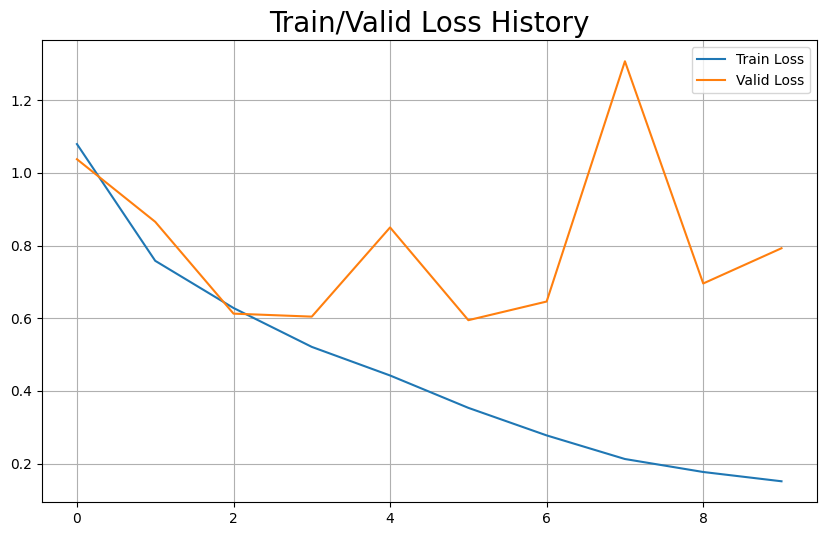

In [21]:
make_plot(result, stage = "Loss")

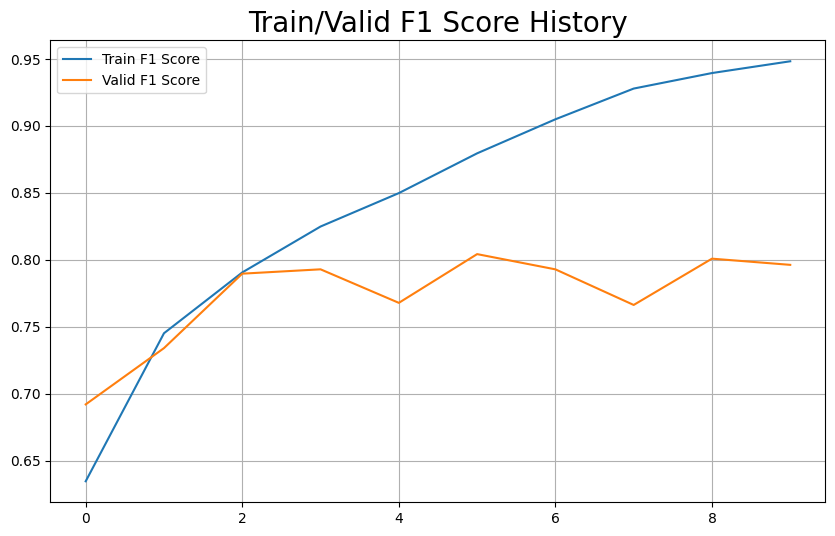

In [22]:
make_plot(result, stage = "F1 Score")

# Visualization

## wandb finish

In [23]:
############ wandb.finish() #################
run.finish()

train_f1_epoch,▁▃▄▅▆▆▇███
train_loss_epoch,█▆▅▄▃▃▂▁▁▁
valid_f1_epoch,▁▄▇▇▆█▇▆█▇
valid_loss_epoch,▅▄▁▁▄▁▂█▂▃
train_f1_epoch,0.94827
train_loss_epoch,0.15125
valid_f1_epoch,0.79618
valid_loss_epoch,0.79259
